In [1]:
import argparse
import os
import torch
import pyro
import json
import math
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import PyroOptim
from torch.optim import Adam
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from scipy.sparse import csr_matrix

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import lightning as L
import torch.nn.functional as F

import subprocess
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]

    return data, spatial_locations, clustering

In [3]:
def prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=100, 
        third_dim=False, 
        log_normalize=True,
        likelihood_mode="PCA",
        num_pcs=5,
        hvg_var_prop=0.5,
    ):

    # Path to your .gz file
    file_path = f'data/{dataset}/transcripts.csv.gz'

    # Read the gzipped CSV file into a DataFrame
    df_transcripts = pd.read_csv(file_path, compression='gzip')
    df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
    df_transcripts.head(), df_transcripts.shape

    # drop cells without ids
    df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

    # drop blanks and controls
    df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

    # prepare spots data
    if spots:
        clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
        clustering.set_spot_size(spot_size)

        data_filepath = f"data/spot_data/{dataset}/hBreast_SPOTSIZE={spot_size}um_z={third_dim}.h5ad"
        if not os.path.exists(data_filepath):
            clustering.create_spot_data(third_dim=third_dim, save_data=True)
            clustering.xenium_spot_data.write_h5ad(data_filepath)
        else:
            clustering.xenium_spot_data = ad.read_h5ad(data_filepath)

        if log_normalize:
            clustering.normalize_counts(clustering.xenium_spot_data)


        if likelihood_mode == "PCA":
            sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=num_pcs)
            data = clustering.xenium_spot_data.obsm["X_pca"]
        elif likelihood_mode == "HVG":
            min_dispersion = torch.distributions.normal.Normal(0.0, 1.0).icdf(hvg_var_prop)
            clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, flavor="seurat", min_mean=0.0125, max_mean=1000, min_disp=min_dispersion)
            clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
            data = clustering.xenium_spot_data.X
        elif likelihood_mode == "ALL":
            data = clustering.xenium_spot_data.X

        spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
    
    # prepare cells data
    else:

        cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
        cells_pivot = cells.pivot_table(index='cell_id', 
                                        columns='feature_name', 
                                        values='count', 
                                        fill_value=0)
        
        location_means = df_transcripts.groupby('cell_id').agg({
            'x_location': 'mean',
            'y_location': 'mean',
            'z_location': 'mean'
        }).reset_index()

        cells_pivot = location_means.join(cells_pivot, on='cell_id')

        if log_normalize:
            # log normalization
            cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

        if likelihood_mode == "PCA":
            pca = PCA(n_components=num_pcs)
            data = pca.fit_transform(cells_pivot.iloc[:, 4:])

        elif likelihood_mode == "HVG":
            genes = cells_pivot.iloc[:, 4:]
            gene_variances = genes.var(axis=0)
            gene_variances = gene_variances.sort_values(ascending=False)
            gene_var_proportions = (gene_variances / sum(gene_variances))
            relevant_genes = list(gene_var_proportions[(gene_var_proportions.cumsum() < hvg_var_prop)].index)
            cells_pivot.iloc[:, 4:] = cells_pivot.iloc[:, 4:][[relevant_genes]]
            data = cells_pivot.iloc[:, 4:]

        elif likelihood_mode == "ALL":
            data = cells_pivot.iloc[:, 4:]

        spatial_locations = cells_pivot[["x_location", "y_location"]]


    return data, spatial_locations, clustering # the last one is to regain var/obs access from original data

In [4]:
DATA_TYPE = "XENIUM"
MIN_CONCENTRATION=0.1
dataset_name = "hBreast"
data_mode = "PCA"
spot_size = 100
num_pcs = 25
hvg_var_prop = 0.9
num_clusters = 7
concentration_amplification = 2.5
sample_for_assignment = True
kmeans_init = True
neighborhood_size = 5
spatial_init = True
spatial_normalize = 0.025
batch_size = 16
neighborhood_agg = "weighted"
uncertainty_values = [0.25, 0.5, 0.75, 0.9, 0.99]
evaluate_markers= False

In [5]:
if DATA_TYPE == "XENIUM":
    # Call prepare_Xenium_data with the appropriate arguments
    gene_data, spatial_locations, original_adata = prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=spot_size, 
        third_dim=False, 
        log_normalize=True, 
        likelihood_mode=data_mode, 
        num_pcs=num_pcs,
        hvg_var_prop=hvg_var_prop
    )
elif DATA_TYPE == "DLPFC":
    gene_data, spatial_locations, original_adata = prepare_DLPFC_data(
        section_id=151507,
        num_pcs=num_pcs,
    )


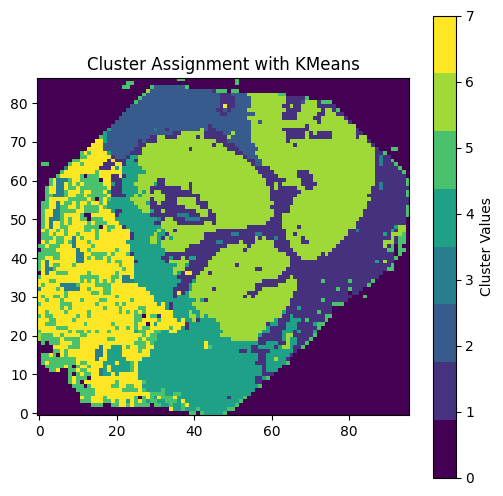

In [6]:
spatial_init_data = gene_data

if spatial_init:

    spatial_init_data = np.concatenate((spatial_locations, gene_data), axis=1)

    if spatial_normalize:

        spatial_init_data = StandardScaler().fit_transform(spatial_init_data)
        spatial_init_data[:, :spatial_locations.shape[1]] *= spatial_normalize

if kmeans_init:

    kmeans = KMeans(n_clusters=num_clusters).fit(spatial_init_data)

    initial_clusters = kmeans.predict(spatial_init_data)
    
    rows = spatial_locations["row"].astype(int)
    columns = spatial_locations["col"].astype(int)

    num_rows = int(max(rows) - min(rows) + 1)
    num_cols = int(max(columns) - min(columns) + 1)

    cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)

    cluster_grid[rows, columns] = torch.tensor(initial_clusters) + 1

    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
    colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    plt.title('Cluster Assignment with KMeans')

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")

    if not os.path.exists(f"results/{dataset_name}/KMeans/clusters/{data_file_path}"):
        os.makedirs(f"results/{dataset_name}/KMeans/clusters/{data_file_path}")
    plt.savefig(
        f"results/{dataset_name}/KMeans/clusters/{data_file_path}/"
        f"KMEANSINIT={kmeans_init}_NEIGHBORSIZE={neighborhood_size}_NUMCLUSTERS={num_clusters}"
        f"_SPATIALINIT={spatial_init}_SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"_SPATIALNORM={spatial_normalize}_SPATIALPRIORMULT={concentration_amplification}_SPOTSIZE={spot_size}"
        f".png"
    )

    if dataset_name == "DLPFC":
        # Create a DataFrame for easier handling
        data = pd.DataFrame({
            'ClusterAssignments': initial_clusters,
            'Region': original_adata.xenium_spot_data.obs["Region"]
        })

        # Drop rows where 'Region' is NaN
        filtered_data = data.dropna(subset=['Region'])

        # Calculate ARI and NMI only for the non-NaN entries
        ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        cluster_metrics = {
            "ARI": ari,
            "NMI": nmi
        }

        data_file_path = f"{data_mode}/{num_pcs}"

        if not os.path.exists(f"results/{dataset_name}/KMeans/cluster_metrics/{data_file_path}/"):
            os.makedirs(f"results/{dataset_name}/KMeans/cluster_metrics/{data_file_path}/")
        with open(f"results/{dataset_name}/KMeans/cluster_metrics/{data_file_path}/"
            f"KMEANSINIT={kmeans_init}_NEIGHBORSIZE={neighborhood_size}_NUMCLUSTERS={num_clusters}"
            f"_SPATIALINIT={spatial_init}_SAMPLEFORASSIGNMENT={sample_for_assignment}"
            f"_SPATIALNORM={spatial_normalize}_SPATIALPRIORMULT={concentration_amplification}_SPOTSIZE={spot_size}"
            f".json", 'w') as fp:
            json.dump(cluster_metrics, fp)

    concentration_priors = torch.tensor(pd.get_dummies(initial_clusters, dtype=float).to_numpy())

else:

    concentration_priors = torch.ones((len(gene_data), num_clusters), dtype=float)

concentration_w_locations = torch.cat((torch.tensor(spatial_locations.to_numpy()), concentration_priors), dim=1)

# Clone to avoid modifying the original tensor
spatial_concentration_priors = concentration_priors.clone()
# Number of features in the concentration data
num_features = concentration_priors.shape[1]

# Compute the number of elements in each dimension
num_elements = concentration_priors.shape[0]

# Precompute all distance pairs between locations
dist_x = torch.abs(concentration_w_locations[:, None, 0] - concentration_w_locations[None, :, 0])
dist_y = torch.abs(concentration_w_locations[:, None, 1] - concentration_w_locations[None, :, 1])

# Compute neighborhood mask based on the neighborhood size
mask = (dist_x <= neighborhood_size) & (dist_y <= neighborhood_size)

if neighborhood_agg not in ["sum", "mean"]:
    def weighting_function(x):
        return torch.where(x != 0, 1 / (x ** 2), torch.zeros_like(x)).reshape(-1,1)
    distances_in_neighborhood = (dist_x + 1) * (dist_x <= neighborhood_size) + (dist_y + 1) * (dist_y <= neighborhood_size)

# Apply the mask to compute the sum of the neighborhood
for i in range(num_elements):
    # Select the mask for the current element
    current_mask = mask[i]
    # Compute the sum of elements in the neighborhood
    if neighborhood_agg == "sum":
        neighborhood_expression = concentration_priors[current_mask].sum(dim=0)
    elif neighborhood_agg == "mean":
        neighborhood_expression = concentration_priors[current_mask].mean(dim=0)
    else:
        weighted_A = weighting_function(distances_in_neighborhood[i][current_mask])
        neighborhood_expression = (weighted_A * concentration_priors[current_mask]).sum(dim=0)

    # Update the spatial concentration priors with the mean or sum as required
    spatial_concentration_priors[i] += neighborhood_expression

concentration_priors = spatial_concentration_priors
concentration_priors += torch.distributions.half_normal.HalfNormal(0.1).sample((concentration_priors.shape))
concentration_priors /= concentration_priors.sum(dim=1).unsqueeze(1)
concentration_priors *= concentration_amplification
concentration_priors = concentration_priors.float()


# for numerical stability
gene_data = StandardScaler().fit_transform(gene_data)
data = torch.tensor(gene_data).float()

# Helper for making fully-connected neural networks
def make_fc(dims):
    layers = []
    for in_dim, out_dim in zip(dims, dims[1:]):
        layers.append(torch.nn.Linear(in_dim, out_dim))
        layers.append(torch.nn.BatchNorm1d(out_dim))
        layers.append(torch.nn.ReLU())
    layers[-1] = torch.nn.Softmax(dim=1)
    return torch.nn.Sequential(*layers) 

# Encoder
# Neural Network for the Encoder (Guide)
class Encoder(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.network = make_fc(dims)

    def forward(self, x):
        return torch.clamp(self.network(x), min=0.1)
    
# Initialize the neural network
dims = (data.size(1), 128, 64, num_clusters)
z_dim = num_clusters
encoder = Encoder(dims)

In [7]:
# Clear the param store in case we're in a REPL
pyro.clear_param_store()

def model(data):

    # Define the means and variances of the Gaussian components
    cluster_means = pyro.sample("cluster_means", dist.Normal(0., 1.).expand([num_clusters, data.size(1)]).to_event(2))
    cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(0., 1.).expand([num_clusters, data.size(1)]).to_event(2))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        batch_concentration_priors = concentration_priors[ind]
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(batch_concentration_priors))
        # Likelihood of data given cluster assignments
        for i in range(cluster_probs.size(0)):
            pyro.sample(f"obs_{i}", dist.MixtureOfDiagNormals(cluster_means, cluster_scales, cluster_probs[i]), obs=batch_data[i])

def guide(data):
    pyro.module("encoder", encoder)
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive) + MIN_CONCENTRATION
    # Global variational parameters for means and scales
    cluster_means_q_mean = pyro.param("cluster_means_q", torch.ones(num_clusters, data.size(1)))
    cluster_scales_q_mean = pyro.param("cluster_scales_q", torch.ones(num_clusters, data.size(1)), constraint=dist.constraints.positive)
    cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q_mean, 1.0).to_event(2))
    cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q_mean, 1.0).to_event(2))
    
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        cluster_concentration_params_q[ind] = (concentration_amplification * encoder(batch_data)).float()
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q[ind]))

In [8]:
print(len(data))
print(data.shape, concentration_priors.shape)

print(pyro.render_model(model, model_args=(data,), render_distributions=True, render_params=True))

6138
torch.Size([6138, 25]) torch.Size([6138, 7])
digraph {
	cluster_means [label=cluster_means fillcolor=white shape=ellipse style=filled]
	cluster_scales [label=cluster_scales fillcolor=white shape=ellipse style=filled]
	subgraph cluster_data {
		label=data labeljust=r labelloc=b
		cluster_probs [label=cluster_probs fillcolor=white shape=ellipse style=filled]
		obs_0 [label=obs_0 fillcolor=gray shape=ellipse style=filled]
		obs_1 [label=obs_1 fillcolor=gray shape=ellipse style=filled]
		obs_2 [label=obs_2 fillcolor=gray shape=ellipse style=filled]
		obs_3 [label=obs_3 fillcolor=gray shape=ellipse style=filled]
		obs_4 [label=obs_4 fillcolor=gray shape=ellipse style=filled]
		obs_5 [label=obs_5 fillcolor=gray shape=ellipse style=filled]
		obs_6 [label=obs_6 fillcolor=gray shape=ellipse style=filled]
		obs_7 [label=obs_7 fillcolor=gray shape=ellipse style=filled]
		obs_8 [label=obs_8 fillcolor=gray shape=ellipse style=filled]
		obs_9 [label=obs_9 fillcolor=gray shape=ellipse style=fill

In [9]:
NUM_EPOCHS = 100
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

# Setup the optimizer
adam_params = {"lr": 0.0001, "betas": (0.90, 0.999), "weight_decay": 1e-5}
scheduler = PyroOptim(Adam, adam_params)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=Trace_ELBO(num_particles=10))

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
    # svi.optim.step()
    if epoch % 1 == 0:
        print(f"Step {epoch} : loss = {round(running_loss/1e6, 4)}")
        cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive)
        if sample_for_assignment:
            cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q)).detach()     
        else:
            # the probs aren't sampled and we calculate the EV instead
            cluster_probs_q = cluster_concentration_params_q.softmax(dim=1)
        cluster_assignments_q = cluster_probs_q.argmax(dim=1)

        if dataset_name == "DLPFC":
            # Create a DataFrame for easier handling
            cluster_data = pd.DataFrame({
                'ClusterAssignments': cluster_assignments_q,
                'Region': original_adata.xenium_spot_data.obs["Region"]
            })

            # Drop rows where 'Region' is NaN
            filtered_data = cluster_data.dropna(subset=['Region'])

            # Calculate ARI and NMI only for the non-NaN entries
            ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
            nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
            print(f"Step {step} : ARI = {ari} NMI = {nmi}")

Step 383 : loss = 142.5897
Step 383 : loss = 141.9621
Step 383 : loss = 141.2804
Step 383 : loss = 140.9366
Step 383 : loss = 140.242
Step 383 : loss = 139.9295
Step 383 : loss = 139.3621
Step 383 : loss = 138.9382
Step 383 : loss = 138.5379
Step 383 : loss = 138.0296
Step 383 : loss = 137.6075
Step 383 : loss = 137.0586
Step 383 : loss = 136.8935
Step 383 : loss = 136.4111
Step 383 : loss = 135.9524
Step 383 : loss = 135.5774
Step 383 : loss = 135.3754
Step 383 : loss = 134.8843
Step 383 : loss = 134.6017
Step 383 : loss = 134.3491
Step 383 : loss = 134.0034
Step 383 : loss = 133.7453
Step 383 : loss = 133.4491
Step 383 : loss = 133.0495
Step 383 : loss = 132.8326
Step 383 : loss = 132.4694
Step 383 : loss = 132.4763
Step 383 : loss = 132.0627
Step 383 : loss = 131.8339
Step 383 : loss = 131.61
Step 383 : loss = 131.4188
Step 383 : loss = 131.2159
Step 383 : loss = 131.1102
Step 383 : loss = 130.9722
Step 383 : loss = 130.8069
Step 383 : loss = 130.7135
Step 383 : loss = 130.5097
Step

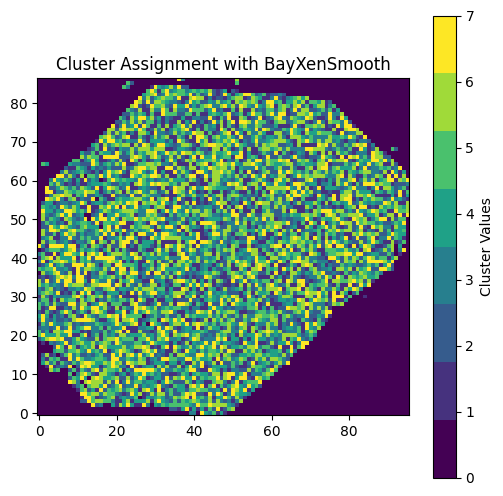

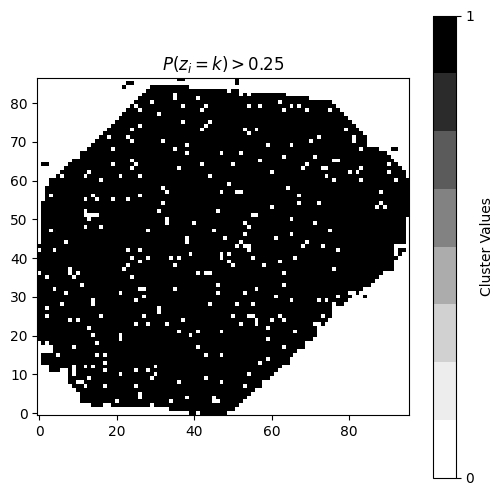

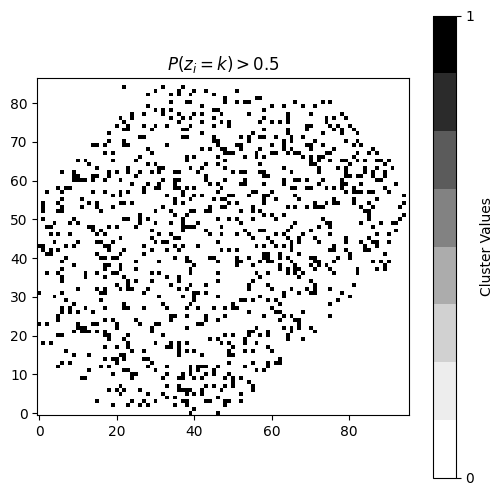

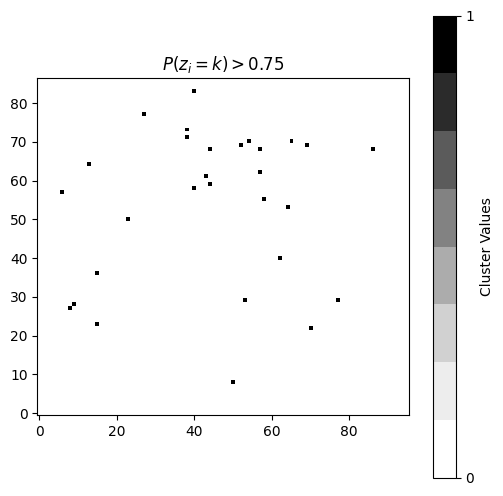

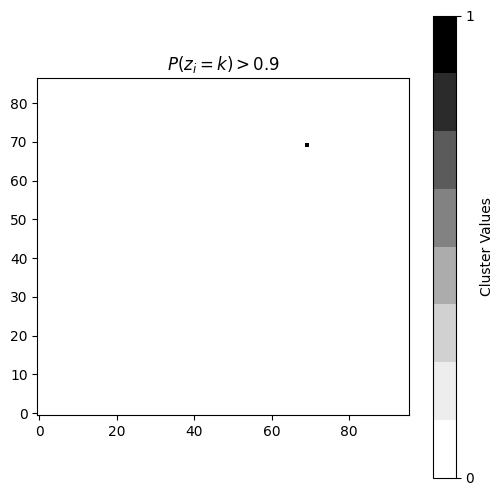

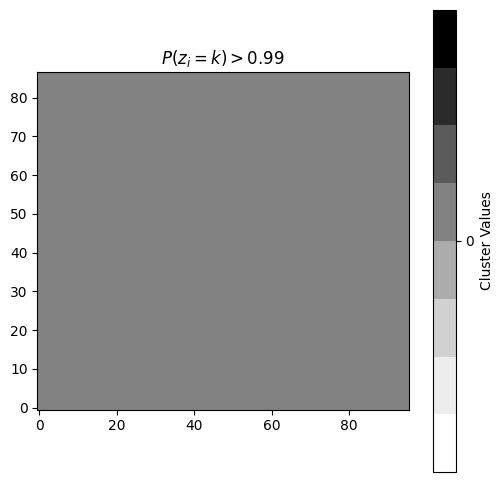

In [11]:
# Grab the learned variational parameters
cluster_concentration_params_q = pyro.param("cluster_concentration_params_q")
if sample_for_assignment:
    cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q)).detach()     
else:
    # the probs aren't sampled and we calculate the EV instead
    cluster_probs_q = cluster_concentration_params_q.softmax(dim=1)
cluster_assignments_q = cluster_probs_q.argmax(dim=1)

cluster_concentration_params_q = cluster_concentration_params_q.detach()
cluster_means_q_mean = pyro.param("cluster_means_q").detach()
cluster_scales_q_mean = pyro.param("cluster_scales_q").detach()

# Plotting
if spot_size:

    rows = spatial_locations["row"].astype(int)
    columns = spatial_locations["col"].astype(int)

    num_rows = int(max(rows) - min(rows) + 1)
    num_cols = int(max(columns) - min(columns) + 1)

    cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid[rows, columns] = cluster_assignments_q + 1

    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
    colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    plt.title('Cluster Assignment with BayXenSmooth')

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")

    if not os.path.exists(f"results/{dataset_name}/BayXenSmooth/clusters/{data_file_path}"):
        os.makedirs(f"results/{dataset_name}/BayXenSmooth/clusters/{data_file_path}")
    plt.savefig(
        f"results/{dataset_name}/BayXenSmooth/clusters/{data_file_path}/"
        f"KMEANSINIT={kmeans_init}_NEIGHBORSIZE={neighborhood_size}_NUMCLUSTERS={num_clusters}"
        f"_SPATIALINIT={spatial_init}_SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"_SPATIALNORM={spatial_normalize}_SPATIALPRIORMULT={concentration_amplification}_SPOTSIZE={spot_size}"
        f".png"
    )

    # grab the WSS distance of cluster labels
    wss = {}
    for label in range(1, num_clusters + 1):
        current_cluster_locations = torch.stack(torch.where((cluster_grid == label)), axis=1).to(float)
        wss[f"Cluster {label}"] = (spot_size ** 2) * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations)).item()

    if not os.path.exists(f"results/{dataset_name}/BayXenSmooth/wss/{data_file_path}/"):
        os.makedirs(f"results/{dataset_name}/BayXenSmooth/wss/{data_file_path}/")
    with open(f"results/{dataset_name}/BayXenSmooth/wss/{data_file_path}/"
        f"KMEANSINIT={kmeans_init}_NEIGHBORSIZE={neighborhood_size}_NUMCLUSTERS={num_clusters}"
        f"_SPATIALINIT={spatial_init}_SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"_SPATIALNORM={spatial_normalize}_SPATIALPRIORMULT={concentration_amplification}_SPOTSIZE={spot_size}"
        f".json", 'w') as fp:
        json.dump(wss, fp)

    cmap = get_cmap('rainbow')

    if isinstance(original_adata.xenium_spot_data.X, csr_matrix):
        labels = np.unique(cluster_assignments_q)  # Define the number of clusters
        gene_columns = original_adata.xenium_spot_data.var.index  # Column names from another source
        mean_expression_by_cluster = pd.DataFrame(columns=gene_columns)

        # Loop through each cluster label
        for label in labels:
            # Find indexes of current cluster
            current_cluster_indexes = torch.where(cluster_assignments_q == label)[0].numpy()
            
            # Efficiently extract the rows for the current cluster using fancy indexing
            expressions = original_adata.xenium_spot_data.X[current_cluster_indexes, :]
            print(label, expressions.shape)
            
            # Compute mean expressions; the result is still a csr_matrix
            mean_expressions = expressions.mean(axis=0)
            
            # Convert mean_expressions to a dense format and then to a DataFrame
            mean_expressions_df = pd.DataFrame(mean_expressions.A, columns=gene_columns)
            
            # Append the result to the mean_expression_by_cluster DataFrame
            mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions_df], ignore_index=True)
    else:
        # identify marker genes within each cluster
        mean_expression_by_cluster = pd.DataFrame(columns=original_adata.xenium_spot_data.var.index)

        for label in range(num_clusters):
            current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0])
            expressions = pd.DataFrame(original_adata.xenium_spot_data.X, columns=original_adata.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
            mean_expressions = expressions.mean(axis=0).to_frame().T
            mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

    if evaluate_markers:
        for i, gene in enumerate(mean_expression_by_cluster.columns):
            # using subplots() to draw vertical lines 
            fig, ax = plt.subplots(figsize=(6, 6)) 
            ax.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
            
            # drawing the markers
            ax.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
            ax.set_ylim(0) 
            
            # formatting and details 
            ax.set_xlabel('Cluster Label') 
            ax.set_ylabel('Mean Expression') 
            ax.set_title(gene) 
            ax.set_xticks(mean_expression_by_cluster[gene].index) 
            if not os.path.exists(f"results/{dataset_name}/BayXenSmooth/expressions/{data_file_path}/"):
                os.makedirs(f"results/{dataset_name}/BayXenSmooth/expressions/{data_file_path}/")
            plt.savefig(
                f"results/{dataset_name}/BayXenSmooth/expressions/{data_file_path}/"
                f"KMEANSINIT={kmeans_init}_NEIGHBORSIZE={neighborhood_size}_NUMCLUSTERS={num_clusters}"
                f"_SPATIALINIT={spatial_init}_SAMPLEFORASSIGNMENT={sample_for_assignment}"
                f"_SPATIALNORM={spatial_normalize}_SPATIALPRIORMULT={concentration_amplification}_SPOTSIZE={spot_size}"
                f"_GENE={gene}.png"
            )
    
    # confidence mapping
    cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.float)

    cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

    colors = plt.cm.get_cmap('Greys', num_clusters + 1)
    colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

    # confidence map plotting
    for uncertainty_value in uncertainty_values:
        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        # PLOT ALL UNCERTAINTY VALUESs
        plt.title(r'$P(z_i = k) > $' + f'{uncertainty_value}')
        if not os.path.exists(f"results/{dataset_name}/BayXenSmooth/uncertainty/{data_file_path}/"):
            os.makedirs(f"results/{dataset_name}/BayXenSmooth/uncertainty/{data_file_path}/")
        plt.savefig(
            f"results/{dataset_name}/BayXenSmooth/uncertainty/{data_file_path}/"
            f"CONFIDENCE={uncertainty_value}_KMEANSINIT={kmeans_init}_NEIGHBORSIZE={neighborhood_size}_NUMCLUSTERS={num_clusters}"
            f"_SPATIALINIT={spatial_init}_SAMPLEFORASSIGNMENT={sample_for_assignment}"
            f"_SPATIALNORM={spatial_normalize}_SPATIALPRIORMULT={concentration_amplification}_SPOTSIZE={spot_size}"
            f".png"
        )

else:

    plt.scatter(spatial_locations["x_location"], spatial_locations["y_location"], s=1, c=cluster_assignments_q)
    plt.savefig(
        f"results/{dataset_name}/BayXenSmooth/clusters/{data_file_path}/"
        f"KMEANSINIT={kmeans_init}_NEIGHBORSIZE={neighborhood_size}_NUMCLUSTERS={num_clusters}"
        f"_SPATIALINIT={spatial_init}_SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"_SPATIALNORM={spatial_normalize}_SPATIALPRIORMULT={concentration_amplification}_SPOTSIZE={spot_size}.png"
    )